<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

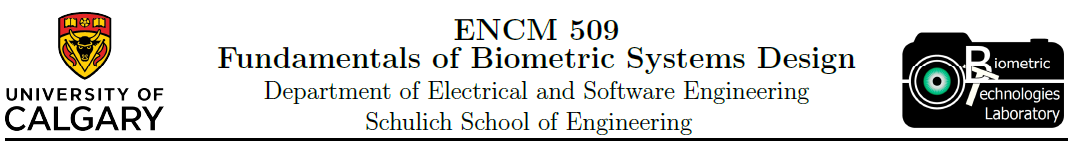

<center>
    <h1>Laboratory Experiment #4</h1>
    <h3>Fingerprint Biometrics - Part I: Preprocessing and Feature Extraction</h3>
</center>

---
---

# ENCM 509 Lab 4 Report

#### Names: Ahad Ali, Avijot Girn
#### UCID: 30088786, 30117825
#### Group #: Group 35

---
---

## Introduction

TODO: Avi (mention how helper code for exercises placed below/in this section)

In [1]:
# Import necessary libraries
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

# from scipy.signal.signaltools import wiener # DeprecationWarning suggested below instead
from scipy.signal import wiener

from utils_encm.poincare import calculate_singularities
from utils_encm.segmentation import segmentation
from utils_encm.normalization import normalize
from utils_encm.gabor_filter import gabor_filter
from utils_encm.frequency import ridge_freq
from utils_encm.orientation import calculate_angles, visualize_angles
from utils_encm.crossing_number import calculate_minutiae
from utils_encm.skeletonize import skeletonize
from utils_encm.MatchGaborFeat import MatchGaborFeat
from utils_encm.align2 import align2
from utils_encm.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

## **Exercise 1** (3 marks): 

Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

In [12]:
# ** Helper Function used for fingerprint image processing - used in Exercises 1-3; reduces redundancy
def fingerprint_processing(img, block_size=16, threshold=0.4):
    """
    This helper function bundles all the provided template code in a single function as to reduce redundancy and improve code modularity.
    Below are the core steps being done in this function:
        1. Normalization: Image Pixel Intensity normalized within a pre-determined range
        2. Segmentation: Extract Fingerprint Area from Background and Find its Contour
        3. Orientation Estimation: Compute Orientation Array at every Pixel
        4. Frequency Estimation: Compute Local Ridge Frequencies (Congestion)
        5. Gabor Filtering: Implement Directional Filters to Enhance Ridges
        6. Thinning: Remove Spurious Pixels from Skeleton (Keeping Ridges 1px wide)
        7. Minutiae Detection: Determine Minutiae Points Coordinates
        8. Singularities Detection: Find Points of cores, deltas, whorl, loop, etc.
    """
    
    output = {}
    
    # 1. normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # 2. segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # 3. orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # 4. find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # 5. create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # 6. create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # 7. find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('\tTotal of minutiae detected: %d' % (len(minutiae_lst)))
    
    # 8. singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('\tTotal of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [10]:
# ** Helper Function - used in Exercises 1 and 3; reduces redundancy
def histogram_equalization(fingerprint_path):
    """
    This helper function loads, wraps the above processing function and performs histogram equalization.
    Below are the core steps being done in this function:
        1. Load: Load Fingerprint bmp image from data collected during the lab
        2. Processing: Wrap/Call above helper function for Fingerprint Processing
        3. Histogram Equalization: Enhance Contrast Before Extracting Minutiae
        4. Logging: Print Minutiae/Singularities detected with and without Histogram Equalization
    """
    
    # 1. Load
    fingerprint_image = img_as_ubyte(imread(fingerprint_path, as_gray=True))

    # 2. & 4. Processing + Logging
    print('---')
    print('Processing without Equalization')
    processed_fingerprint = fingerprint_processing(fingerprint_image)
    
    
    # 3. & 4. Histogram Equalization + Logging
    print('---')
    print('Processing with Equalization')
    fp_image_hist = img_as_ubyte(equalize_hist(fingerprint_image))
    fp_image_adapthist = img_as_ubyte(equalize_adapthist(fingerprint_image))
    processed_fp_adapthist = fingerprint_processing(fp_image_adapthist)
    
    output = [
        fingerprint_image,
        # processed_fingerprint,
        fp_image_hist,
        fp_image_adapthist,
        # processed_fp_adapthist
    ]
    
    return output

In [6]:
# ** Helper Function - used in Exercises 1 and 3; reduces redundancy
def plot_fp_pixel_intensity(original_image, hist_image, adapthist_image):
    """
    This helper function plots the fingerprint without histogram equalization and with regular and adaptive histogram equalization.
    """
    
    plt.figure(figsize=(14,6))
    plt.subplot(2,3,1)
    plt.imshow(original_image)
    plt.title('Original image')
    plt.subplot(2,3,2)
    plt.imshow(hist_image)
    plt.title('Regular Equalization')
    plt.subplot(2,3,3)
    plt.imshow(adapthist_image)
    plt.title('Adaptive Equalization')
    plt.subplot(2,3,4)
    plt.hist(original_image.ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity')
    plt.subplot(2,3,5)
    plt.hist(hist_image.ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity')
    plt.subplot(2,3,6)
    plt.hist(adapthist_image.ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity')

---
Processing without Equalization
	Total of minutiae detected: 39
	Total of singularities detected: 4
---
Processing with Equalization
	Total of minutiae detected: 49
	Total of singularities detected: 4


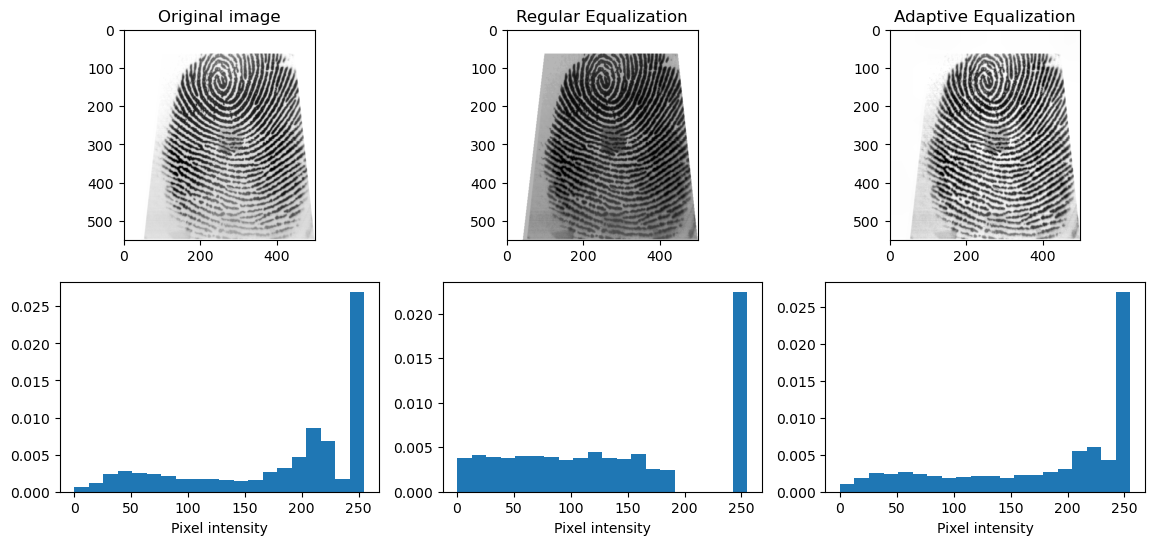

In [14]:
# 1. Plot (Relatively) Good Right Fingerprint
good_right_fp_path = './in_lab_fingerprints/Ahad/right/2.bmp' # has the most pressure and most part of my fingerprint visible
original_good_right_fp, hist_good_right_fp, adapthist_good_right_fp = histogram_equalization(good_right_fp_path)
plot_fp_pixel_intensity(original_good_right_fp, hist_good_right_fp, adapthist_good_right_fp)

---
Processing without Equalization
	Total of minutiae detected: 29
	Total of singularities detected: 0
---
Processing with Equalization
	Total of minutiae detected: 49
	Total of singularities detected: 0


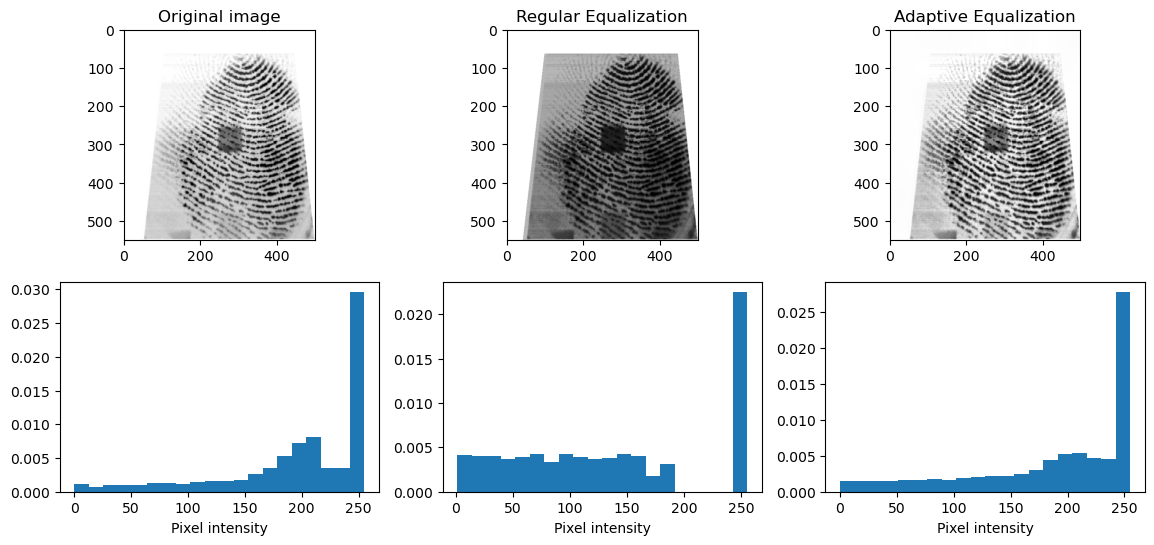

In [16]:
# 2. Plot (Relatively) Bad Right Fingerprint
bad_right_fp_path = './in_lab_fingerprints/Ahad/right/1.bmp' # has the least part of my fingerprint visible (most cut off)
original_bad_right_fp, hist_bad_right_fp, adapthist_bad_right_fp = histogram_equalization(bad_right_fp_path)
plot_fp_pixel_intensity(original_bad_right_fp, hist_bad_right_fp, adapthist_bad_right_fp)

---
Processing without Equalization
	Total of minutiae detected: 69
	Total of singularities detected: 8
---
Processing with Equalization
	Total of minutiae detected: 100
	Total of singularities detected: 8


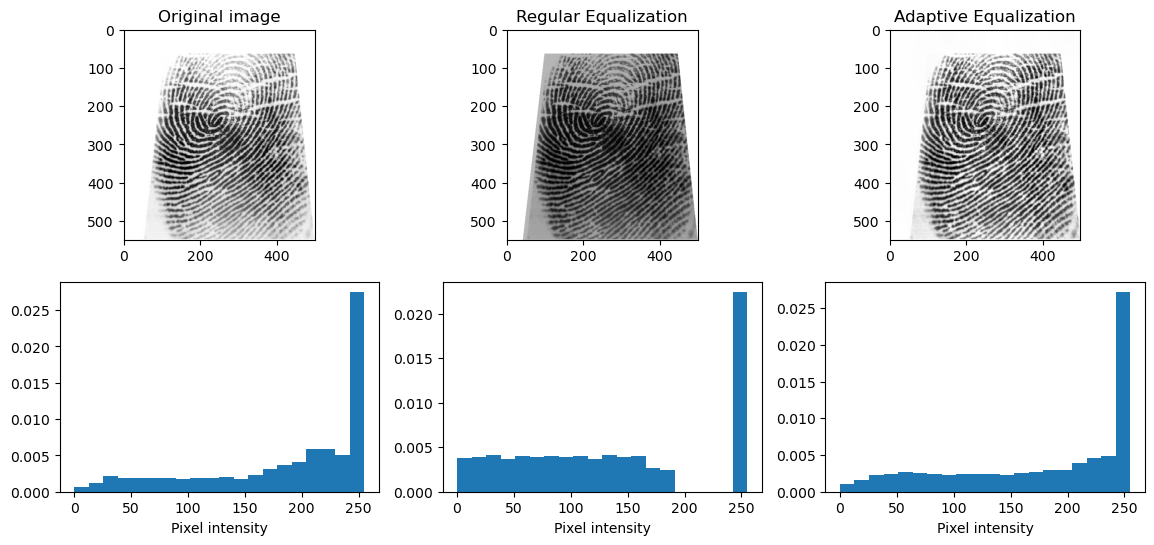

In [20]:
# 3. Plot (Relatively) Good Left Fingerprint
good_left_fp_path = './in_lab_fingerprints/Ahad/left/8.bmp' # has the most pressure and most part of my fingerprint visible/most centered
original_good_left_fp, hist_good_left_fp, adapthist_good_left_fp = histogram_equalization(good_left_fp_path)
plot_fp_pixel_intensity(original_good_left_fp, hist_good_left_fp, adapthist_good_left_fp)

---
Processing without Equalization
	Total of minutiae detected: 41
	Total of singularities detected: 0
---
Processing with Equalization
	Total of minutiae detected: 44
	Total of singularities detected: 0


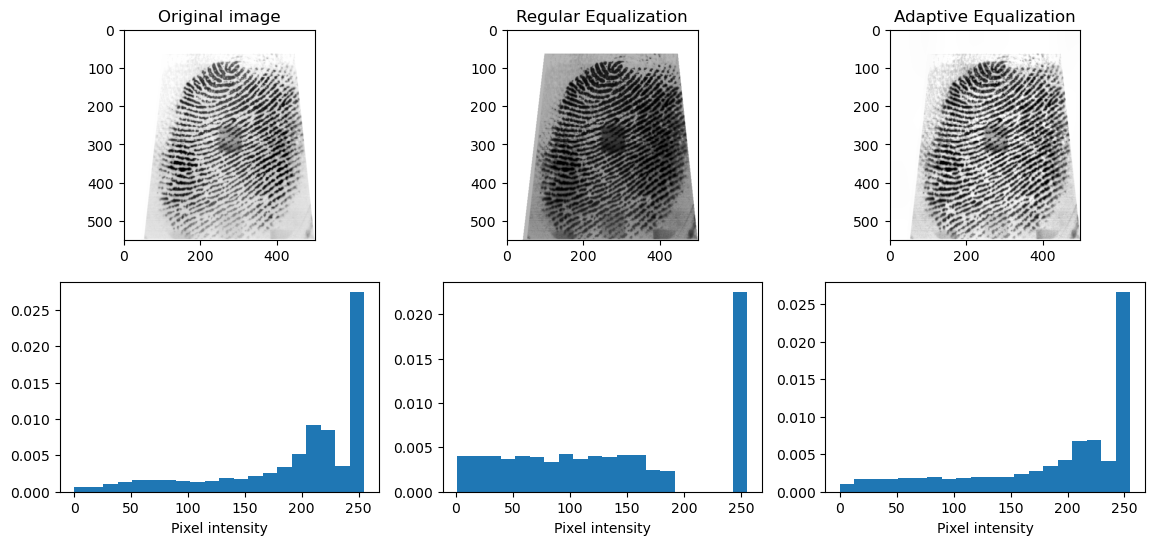

In [22]:
# 4. Plot (Relatively) Bad Left Fingerprint
bad_left_fp_path = './in_lab_fingerprints/Ahad/left/4.bmp' # has the least pressure and least part of my fingerprint visible/least centered
original_bad_left_fp, hist_bad_left_fp, adapthist_bad_left_fp = histogram_equalization(bad_left_fp_path)
plot_fp_pixel_intensity(original_bad_left_fp, hist_bad_left_fp, adapthist_bad_left_fp)

### Analysis and Comparision

To help with the analysis and comparision of the above exercise, below is a summary table of the number of minutae and singularities detected by fingerprint:

**Right Fingerprint**

| Condition | With/Without Equalization | Minutiae | Singularities |
|-----------|---------------------------|----------|---------------|
| Good      | Without                   | 39       | 4             |
| Good      | With                      | 49       | 4             |
| Bad       | Without                   | 29       | 0             |
| Bad       | With                      | 49       | 0             |

**Left Fingerprint**

| Condition | With/Without Equalization | Minutiae | Singularities |
|-----------|---------------------------|----------|---------------|
| Good      | Without                   | 69       | 8             |
| Good      | With                      | 100      | 8             |
| Bad       | Without                   | 41       | 0             |
| Bad       | With                      | 44       | 0             |

Please note when referring to 'With Equalization' above, we are referring specifically to adaptive equalization over regular image equalization. The reason for this is that the assignment handout did not explicity state which one to use and as suggested in the assignment handout/template code, adaptive equalization worked better than regular image equalization. 

Perhaps the most prominent comparision that can be drawn from the above table is that in the case of all four fingerprints, histogram equalization increased the number of minutiae detected. This would make sense as the primary function of equalization is for contrast enhancement. The acquired fingerprint images may have poor contrast, so equalization is an enhancement technique which improves the contrast which should help with minutiae detection. As such, we can see above that for the (relatively) worst fingerprint of the 4 (#2 or Bad Right Fingerprint), the minutaiae detection improved the most by approximately 69% or 20! Furthermore, we see for the (#4) Left Bad Fingerprint the minutae detection only improved by approximately 7% which may indicate that the fingerprint image had good contrast and thereby did not require the contrast enhancement achieved by equalization. 

We also notice above that introducing or utilizing equalization has no impact on singularity detection, indicating it does not improve singularity detection. This makes sense as the assignment handout only explicity states how equalization improves minutiae detection (not singularity detection) through its a contrast enhancement technique. 

On a final note, we would like to note or observe how the (#4) Bad Left Fingerprint has a higher minutiae detection than the (#1) Good Right Fingerprint. This exemplifies how the good and bad condition are relative and is also due to the fact that I started with my right fingerprint/thumb and ended with my left. This means that perhaps the lower minutiae detection can be attributed to the user as they did a better job on their left fingerprint than right fingerprint.  

Finally, please note that these findings are not necessarily conclusive, as seletecting any other set of 4 fingerprints may yield a different result, this is because good/bad is subjective or relative and one might consider a bad fingerprint to be one that's cutoff while another might consider it to be one with less pressure. Therefore, a different set of 4 fingerprints may have yielded different findings.

---
## **Exercise 2** (3 marks): 

In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

In [34]:
# ** Helper Function - used in Exercise 2; reduces redundancy
def wiener_denoising(fingerprint_path):
    """
    This helper function loads, wraps the above processing function and performs the Wiener de-noising method.
    Below are the core steps being done in this function:
        1. Load: Load Fingerprint bmp image from data collected during the lab
        2. Processing: Wrap/Call above helper function for Fingerprint Processing
        3. Wiener De-Noising: Removes noises such as spurious pixels intensities
        4. Logging: Print Minutiae/Singularities detected with and without De-Noising
    """
    
    # 1. Load
    fingerprint_image = img_as_ubyte(imread(fingerprint_path, as_gray=True))

    # 2. & 4. Processing + Logging
    print('---')
    print('Processing without De-Noising')
    processed_fingerprint = fingerprint_processing(fingerprint_image)
    
    
    # 3. & 4. Weiner De-Noising + Logging
    print('---')
    print('Processing with De-Noising')
    # Wiener filter needs the input image as float (not uint8)
    # the (5,5) corresponds to the sized of the window to considered during the processing.
    fp_image_wiener = wiener(fingerprint_image.astype('float'), (5,5))
    # is necessary to convert the output back to uint8. 
    # some additional steps are necessary to have it in 0-255. 
    fp_image_wiener = img_as_ubyte((fp_image_wiener-np.min(fp_image_wiener))/(np.max(fp_image_wiener)-np.min(fp_image_wiener)))

    # with the Median filter is not necessary to convert back to uint8 
    fp_image_median = median(fingerprint_image)
    
    processed_fp_wiener = fingerprint_processing(fp_image_wiener)
    
    
    output = [
        fingerprint_image,
        # processed_fingerprint,
        fp_image_wiener,
        # fp_image_median,
        # processed_fp_wiener
    ]
    
    return output

In [43]:
# ** Helper Function - used in Exercise 2; reduces redundancy
def plot_fp_pixel_intensity_denoising(original_image, wiener_denoising_image):
    """
    This helper function plots the fingerprint without wiener de-noising and with wiener de-noising.
    """
    
    plt.figure(figsize=(14,6))
    plt.subplot(2,2,1)
    plt.imshow(original_image)
    plt.title('Original image')
    plt.subplot(2,2,2)
    plt.imshow(wiener_denoising_image)
    plt.title('Wiener De-Noising')
    plt.subplot(2,2,3)
    plt.hist(original_image.ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity')
    plt.subplot(2,2,4)
    plt.hist(wiener_denoising_image.ravel(), bins=20, density=True)
    plt.xlabel('Pixel intensity')

---
Processing without De-Noising
	Total of minutiae detected: 39
	Total of singularities detected: 5
---
Processing with De-Noising
	Total of minutiae detected: 37
	Total of singularities detected: 4


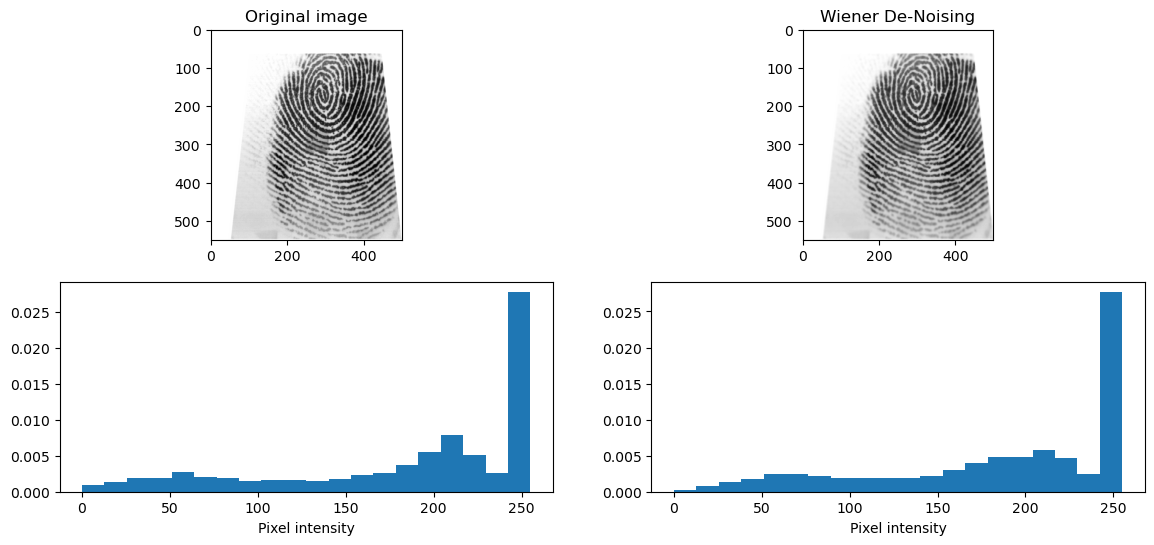

In [44]:
# 1. Plot (Relatively) Good Right Fingerprint
good_right_fp_path = './in_lab_fingerprints/Ahad/right/2.bmp' # has the most pressure and most part of my fingerprint visible
original_good_right_fp, wiener_good_right_fp = wiener_denoising(good_right_fp_path)
plot_fp_pixel_intensity_denoising(original_good_right_fp, wiener_good_right_fp)

---
Processing without De-Noising
	Total of minutiae detected: 29
	Total of singularities detected: 0
---
Processing with De-Noising
	Total of minutiae detected: 20
	Total of singularities detected: 0


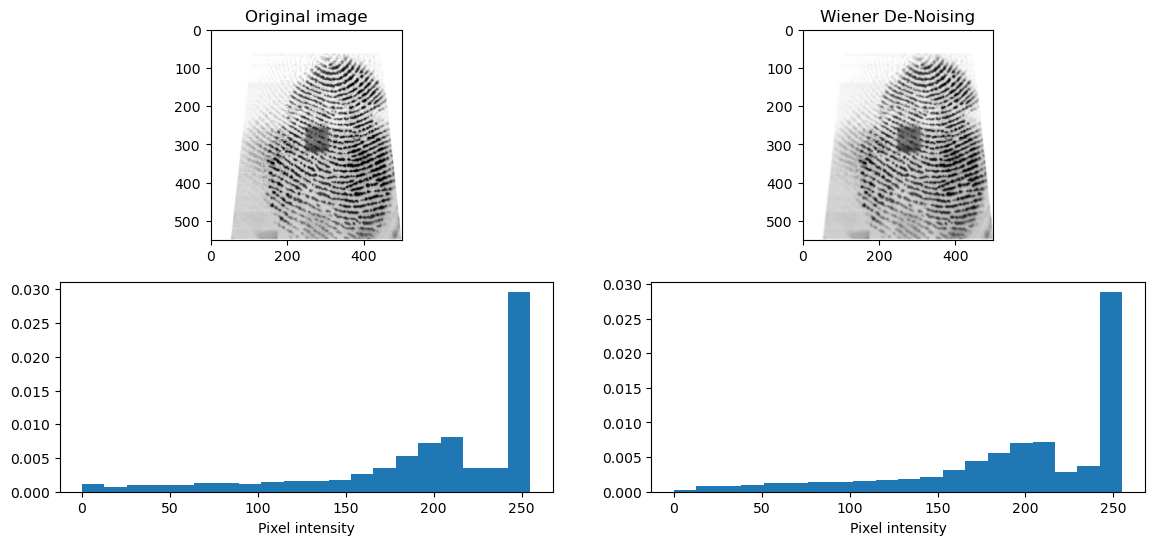

In [45]:
# 2. Plot (Relatively) Bad Right Fingerprint
bad_right_fp_path = './in_lab_fingerprints/Ahad/right/1.bmp' # has the least part of my fingerprint visible (most cut off)
original_bad_right_fp, wiener_bad_right_fp = wiener_denoising(bad_right_fp_path)
plot_fp_pixel_intensity_denoising(original_bad_right_fp, wiener_bad_right_fp)

---
Processing without De-Noising
	Total of minutiae detected: 69
	Total of singularities detected: 8
---
Processing with De-Noising
	Total of minutiae detected: 62
	Total of singularities detected: 6


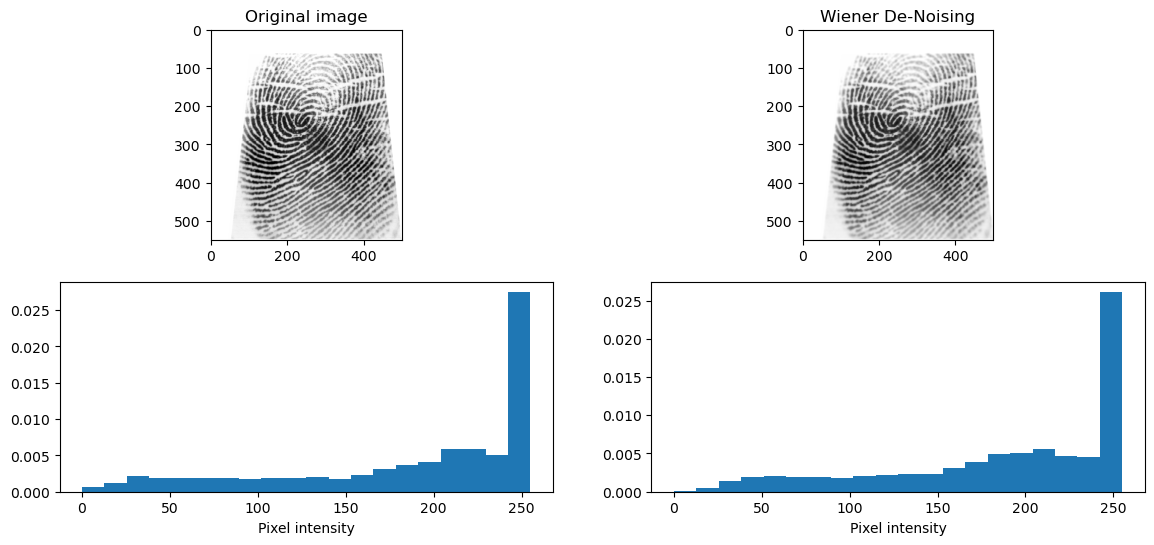

In [46]:
# 3. Plot (Relatively) Good Left Fingerprint
good_left_fp_path = './in_lab_fingerprints/Ahad/left/8.bmp' # has the most pressure and most part of my fingerprint visible/most centered
original_good_left_fp, wiener_good_left_fp = wiener_denoising(good_left_fp_path)
plot_fp_pixel_intensity_denoising(original_good_left_fp, wiener_good_left_fp)

---
Processing without De-Noising
	Total of minutiae detected: 41
	Total of singularities detected: 0
---
Processing with De-Noising
	Total of minutiae detected: 38
	Total of singularities detected: 0


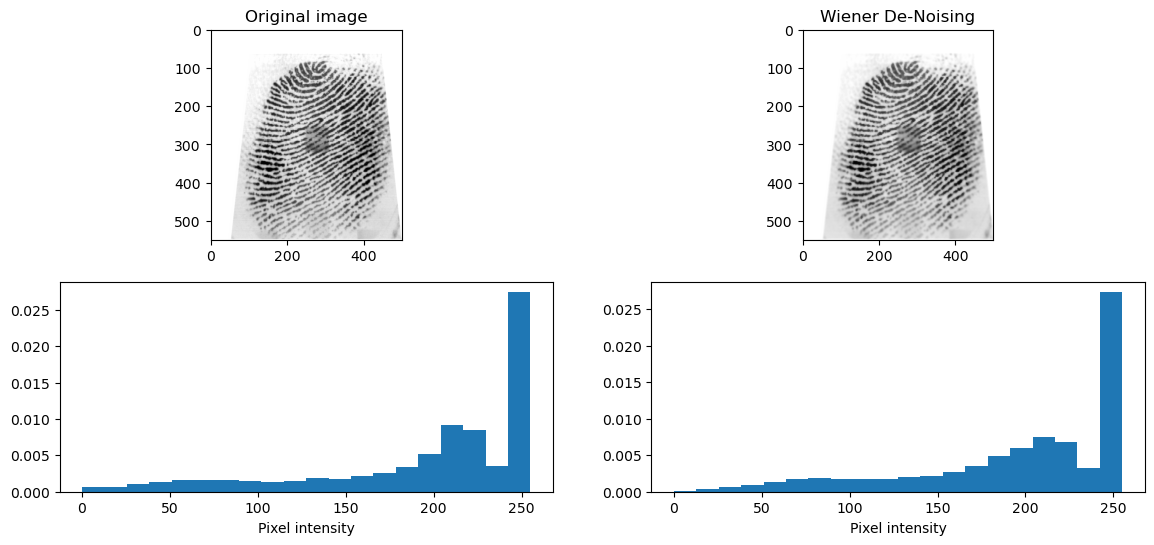

In [47]:
# 4. Plot (Relatively) Bad Left Fingerprint
bad_left_fp_path = './in_lab_fingerprints/Ahad/left/4.bmp' # has the least pressure and least part of my fingerprint visible/least centered
original_bad_left_fp, wiener_bad_left_fp = wiener_denoising(bad_left_fp_path)
plot_fp_pixel_intensity_denoising(original_bad_left_fp, wiener_bad_left_fp)

### Analysis and Comparision

To help with the analysis and comparision of the above exercise, below is a summary table of the number of minutae and singularities detected by fingerprint:

**Right Fingerprint**

| Condition | With/Without De-Noising   | Minutiae | Singularities |
|-----------|---------------------------|----------|---------------|
| Good      | Without                   | 39       | 5             |
| Good      | With                      | 37       | 4             |
| Bad       | Without                   | 29       | 0             |
| Bad       | With                      | 20       | 0             |

**Left Fingerprint**

| Condition | With/Without De-Noising   | Minutiae | Singularities |
|-----------|---------------------------|----------|---------------|
| Good      | Without                   | 69       | 8             |
| Good      | With                      | 62       | 6             |
| Bad       | Without                   | 41       | 0             |
| Bad       | With                      | 38       | 0             |

Please note when referring to 'De-Noising' above, we are referring specifically to wiener de-noising over median de-noising as we were allowed to choose either or and we randomly chose wiener de-noising. 

Perhaps the most prominent comparision that can be drawn from the above table is that in the case of all four fingerprints, wiener de-noising decreased the number of minutiae detected. While this is interesting, this makes sense as the primary function of wiener de-noising is to remove noises as the name suggests. As such, in an attempt to remove noises, the wiener de-noising function may also remove some minutae detected. Furthermore, we see that the drop in minutiae detection without to with de-noising is not that drastic (at least when compared to the increase without to with equalization). This indicates that it only slightly impacts the minutiae detection compared to equalization, since we are using the same fingerprints in both exercises. 

We also notice above that introducing or utilizing wiener de-noising has decreases singularity detection, if there was any singularity detection in the first place. This could most likely be attributed to the same fact as above, which is that in an attempt ot remove noises, the wiener de-noising function may also remove some singularities detected.

These findings suggest that the wiener de-noising function may be poorly calibrated or over-processing the data thereby negatively impacting the identification accuracy.

Finally, please note that these findings are not necessarily conclusive, as seletecting any other set of 4 fingerprints may yield a different result, this is because good/bad is subjective or relative and one might consider a bad fingerprint to be one that's cutoff while another might consider it to be one with less pressure. Therefore, a different set of 4 fingerprints may have yielded different findings.

---
## **Exercise 3** (4 marks): 

In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  

TODO: Avi

---
## Conclusion

TODO: Avi

---
---


---
---

## Lab Template (Delete After Completing Ex. 3)

0 255


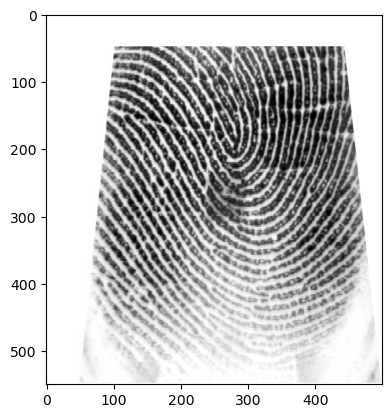

In [5]:
# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
img = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))

# copying the original image in case to use later on
input_img = img.copy()

print(np.min(img), np.max(img))

plt.imshow(img);

### Preprocessing

#### Histogram Equalization

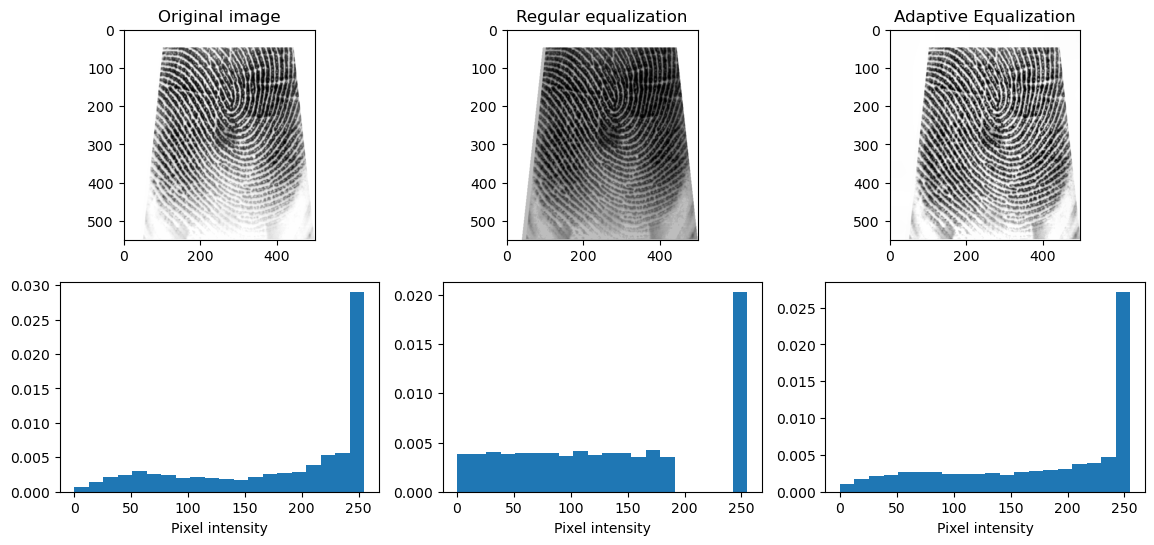

In [6]:
# equalize functions return a float adata 0-1
# to se as uint8 is necessary to convert
img_eq1 = img_as_ubyte(equalize_hist(img))
img_eq2 = img_as_ubyte(equalize_adapthist(img))

plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,3,2)
plt.imshow(img_eq1); plt.title('Regular equalization')
plt.subplot(2,3,3)
plt.imshow(img_eq2); plt.title('Adaptive Equalization');
plt.subplot(2,3,4)
plt.hist(img.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(img_eq1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(img_eq2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity');

#### De-noising

c:\Users\ahada\anaconda3\envs\encm509\lib\site-packages\scipy\signal\_signaltools.py:1659: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\ahada\anaconda3\envs\encm509\lib\site-packages\scipy\signal\_signaltools.py:1659: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


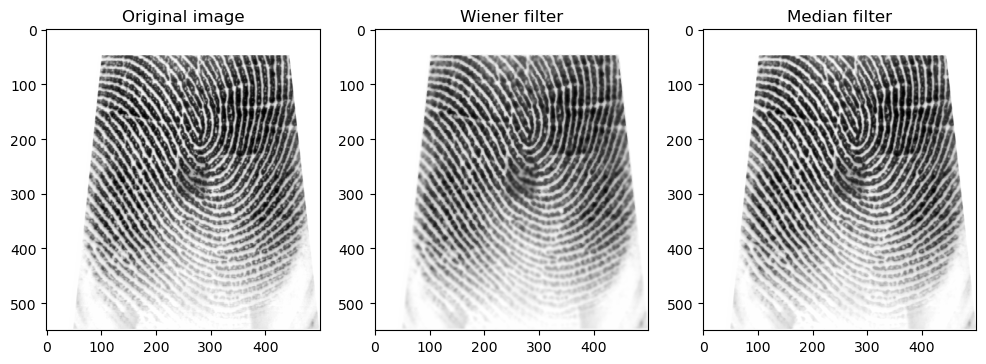

In [7]:
# two different denoising filters are applyed.
# you should chose one

# Wiener filter needs the input image as float (not uint8)
# the (5,5) corresponds to the sized of the window to considered during the processing.
img_wiener = wiener(img.astype('float'), (5,5))
# is necessary to convert the output back to uint8. 
# some additional steps are necessary to have it in 0-255. 
img_wiener = img_as_ubyte((img_wiener-np.min(img_wiener))/(np.max(img_wiener)-np.min(img_wiener)))

# with the Median filter is not necessary to convert back to uint8 
img_median = median(img)

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(img_wiener); plt.title('Wiener filter')
plt.subplot(1,3,3)
plt.imshow(img_median); plt.title('Median filter');

#### Parameters used for the next steps

In [8]:
# block size usend for windowed processing
block_size = 16

# for segmentation
threshold = 0.2

 ### Normalization

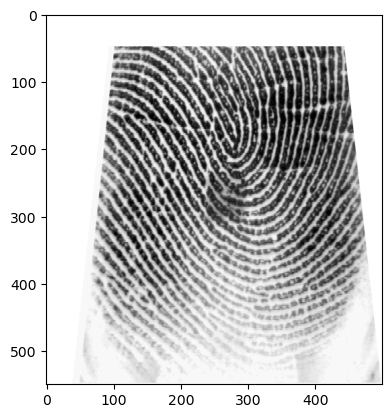

In [9]:
# normalization - removes the effects of sensor noise and finger pressure differences.
normalized_img = normalize(input_img.copy(), float(100), float(100))

plt.imshow(normalized_img);

### Segmentation

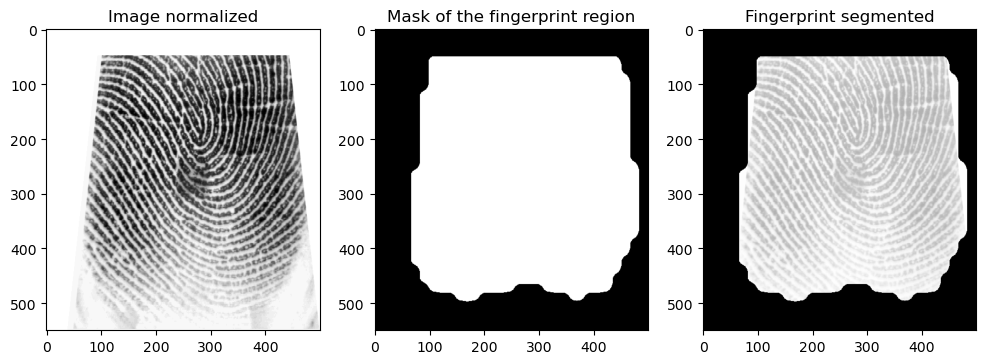

In [10]:
(segmented_img, normim, mask) = segmentation(normalized_img, block_size, threshold)

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(normim); plt.title('Image normalized')
plt.subplot(1,3,2)
plt.imshow(mask); plt.title('Mask of the fingerprint region')
plt.subplot(1,3,3)
plt.imshow(segmented_img); plt.title('Fingerprint segmented');

Text(0.5, 1.0, 'Fingerprint contour')

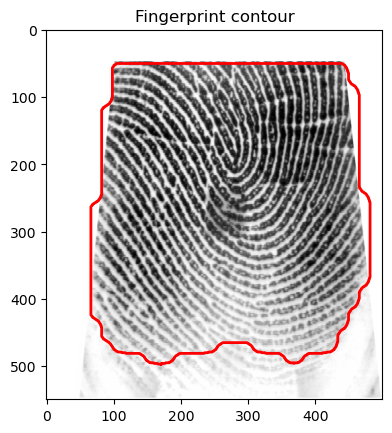

In [11]:
contours = find_contours(mask, 0.8)

plt.imshow(img)
for c in contours:
    plt.plot(c[:, 1], c[:, 0], linewidth=2, c='red')
plt.title('Fingerprint contour')

### Orientation Estimation

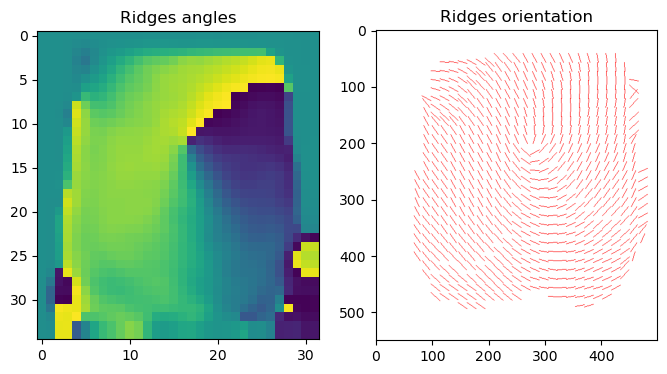

In [12]:
angles = calculate_angles(normalized_img, W=block_size, smooth=True)
orientation_img = visualize_angles(segmented_img, mask, angles, W=block_size)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(angles, cmap='viridis')
plt.title('Ridges angles')
plt.subplot(1,2,2)
plt.imshow(orientation_img)
plt.title('Ridges orientation');

### Ridges Frequency

In [13]:
# find the overall frequency of ridges
freq = ridge_freq(normim, mask, angles, block_size, kernel_size=5, minWaveLength=5, maxWaveLength=15)

### Gabor Filtering

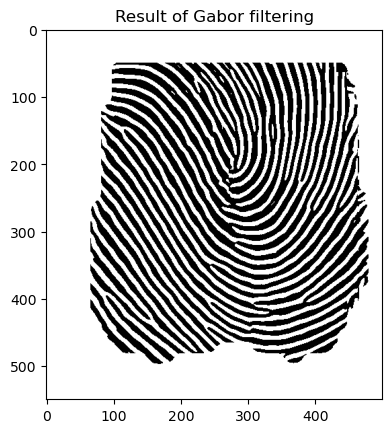

In [14]:
# create gabor filter and do the actual filtering
gabor_img = gabor_filter(normim, angles, freq, block_size2=block_size, kx=0.65, ky=0.65)

plt.imshow(gabor_img, cmap='gray')
plt.title('Result of Gabor filtering');

### Thinning or Skeletonize

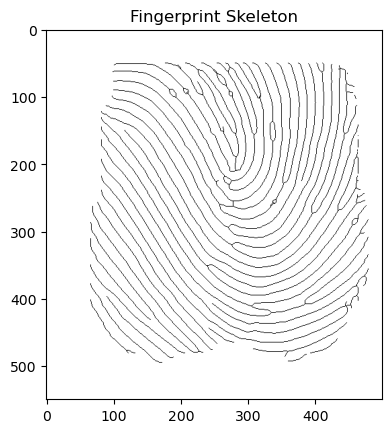

In [15]:
thin_image = skeletonize(gabor_img)

plt.imshow(thin_image, cmap='gray')
plt.title('Fingerprint Skeleton');

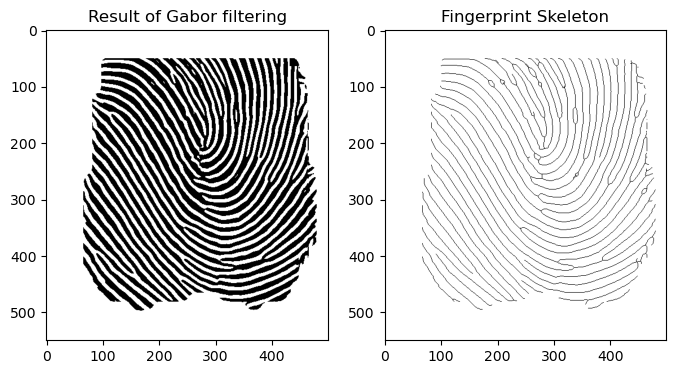

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(gabor_img, cmap='gray')
plt.title('Result of Gabor filtering');
plt.subplot(1,2,2)
plt.imshow(thin_image, cmap='gray')
plt.title('Fingerprint Skeleton');

### Minutiae

Total of minutiae detected: 50


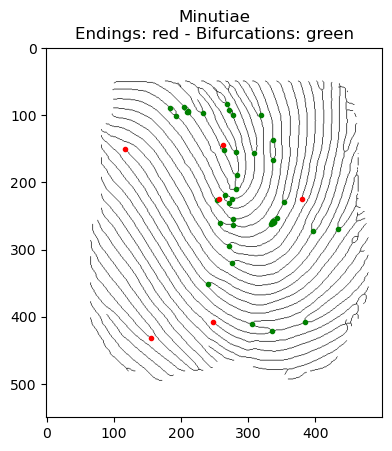

In [17]:
# minutiae_lst is a list with all minutiae coordinates and its type: 
# bifurcation or ending.
# minutiae_img is an image of the minutiae already plot on top of the skeleton
minutiae_lst, minutiae_img, _ = calculate_minutiae(thin_image, mask)

plt.imshow(thin_image)

for p in minutiae_lst:
    x,y = p[0], p[1]
    color = 'red' if p[2] == 'ending' else 'green'
    plt.plot(x,y, color, marker='.')

plt.title('Minutiae\nEndings: red - Bifurcations: green');
print('Total of minutiae detected: %d' % (len(minutiae_lst)))

Total of singularities detected: 4


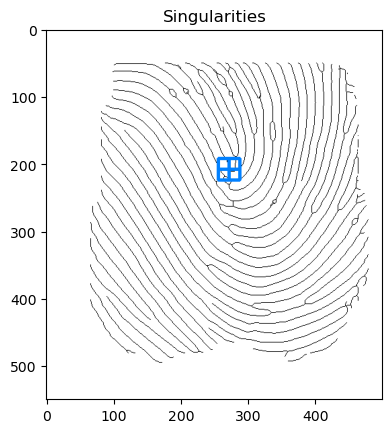

In [18]:
# singularities: whorl, loop and delta.
singularities_lst, singularities_img = calculate_singularities(thin_image, angles, block_size, mask)

plt.imshow(singularities_img)
plt.title('Singularities');
print('Total of singularities detected: %d' % (len(singularities_lst)))

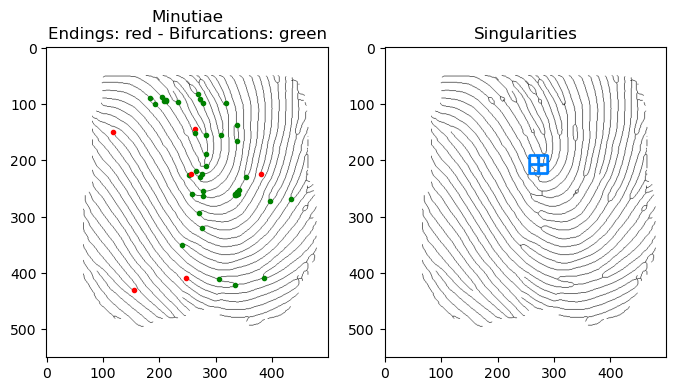

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(thin_image)
for p in minutiae_lst:
    x,y = p[0], p[1]
    color = 'red' if p[2] == 'ending' else 'green'
    plt.plot(x,y, color, marker='.')
plt.title('Minutiae\nEndings: red - Bifurcations: green');
plt.subplot(1,2,2)
plt.imshow(singularities_img)
plt.title('Singularities');

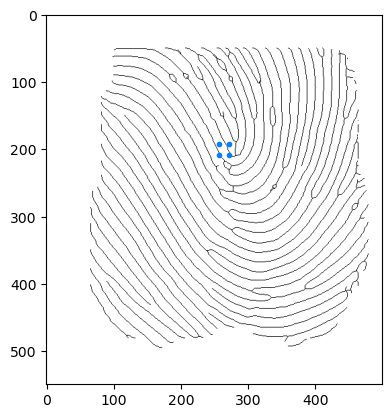

In [20]:
plt.imshow(thin_image)

for p in singularities_lst:
    x,y = p[0], p[1]
    
    # color is defined according to the singularity
    if (p[2] == 'loop'):
        color = 'blue'
    elif (p[2] == 'delta'):
        color = (0, 0.5, 1)
    elif (p[2] == 'whorl'):
        color = (1, 0.6, 1)
        
    plt.plot(x,y, c=color, marker='.')

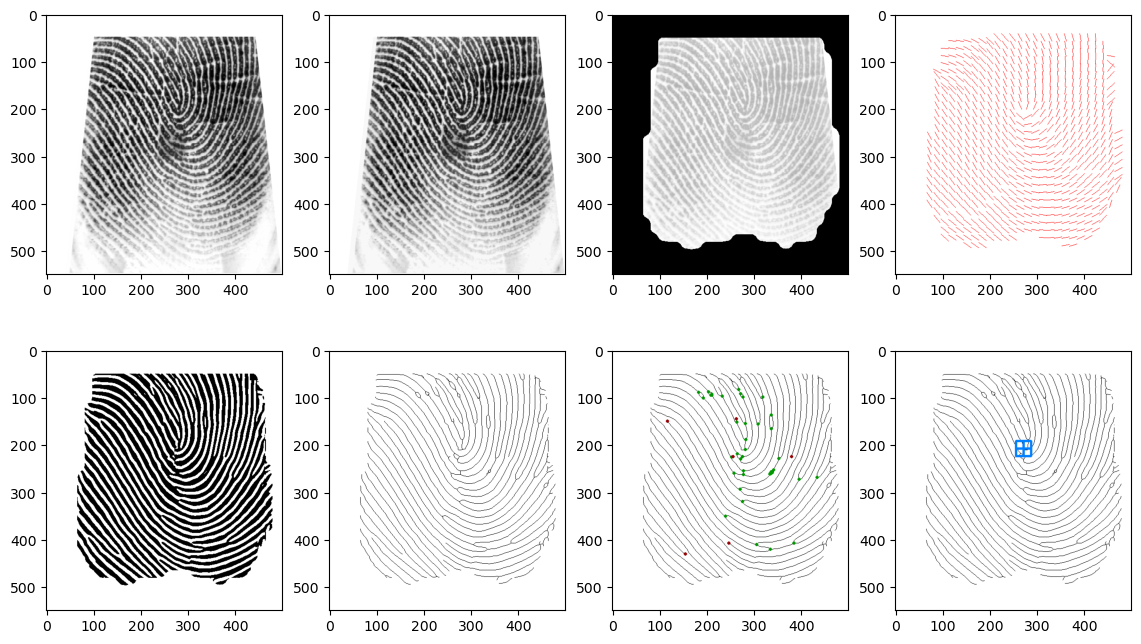

In [21]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_img, cmap='gray');
plt.subplot(2,4,2); plt.imshow(normalized_img, cmap='gray')
plt.subplot(2,4,3); plt.imshow(segmented_img, cmap='gray');
plt.subplot(2,4,4); plt.imshow(orientation_img);
plt.subplot(2,4,5); plt.imshow(gabor_img, cmap='gray');
plt.subplot(2,4,6); plt.imshow(thin_image, cmap='gray');
plt.subplot(2,4,7); plt.imshow(minutiae_img);
plt.subplot(2,4,8); plt.imshow(singularities_img);

### All the steps above compiled in one function

In [22]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

## Matching

##### Loading and processing

In [21]:
# loading two images for Minutiae extraction and matching
im1 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
im2 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/2.bmp', as_gray=True))

# parameters for processing
seg_threshold = 0.4
block_size = 16

# processing
Fp1 = fingerprint_processing(im1, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(im2, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 47
Total of singularities detected: 4
Total of minutiae detected: 84
Total of singularities detected: 4


##### Score based on Minutiae

In [22]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp1, Fp2)
Fp2['imSkeletonAlign'] = imSkeletonAlign
Fp2['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
score = match(Fp1, Fp2, threshold2=match_threshold)
print('score for minutiae: %.4f\n' % (score))

number of matched minutiae: 3
distance total computed : 11
number of minutiae in input image: 748
number of minutiae in database image: 64
score for minutiae: 0.0074



#### Score based on Gabor features

In [23]:
score2 = MatchGaborFeat(im1, im2)
print('Score using Gabor features: %.4f' % (score2))

Score using Gabor features: 13.0024


## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

**PART I (Lab 4): Specific Questions** 

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (3 marks): Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

- **Exercise 2** (3 marks): In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

- **Exercise 3** (4 marks): In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  

**PART II (Lab 5): Specific Questions** 

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (1 mark): Use the demo file to perform the Gabor filtering for ridge detection on your fingerprint image, while adjusting the parameters `frequency` and `angle` of the filter. Choose two different values for each of those parameters, one at a time, and visually evaluate the results. What is the impact of  changing the parameters of the Gabor filtering results (visually)? Draw the conclusions.

- **Exercise 2** (3 marks): Use 9 of your fingerprints as a database, or a gallery. Use the remaining one as a  probe. The database of 9 templates (feature vectors) represents the same "individual".

    Develop a simple identification procedure (use loops that repeat 1 to 1 matching several times), to  match  a probed fingerprint of your finger (e.g. left thumb) against 9 different impressions of the same   finger. Use the Jupyter notebook `Lab04Fingerprint1.ipynb` that performs 1 to 1 matching. 
        
    Record the scores (use a table - see the first Lab on Markdown how to do a table in Jupyter notebooks) for the **minutiae based matching**. Note that for this type of matching, the higher the score the better the match.

    Record the number of matches against the same fingers (True Positives - TP), and the number of mismatches against the same fingers (False Negatives - FN). How the choice of the threshold affects the  matching? Use the numbers or graphs to illustrate your answer.

- **Exercise 3** (2 marks): Repeat the same experiment (using the same images) from Exercise 2, but **instead of minutiae based matching, use the method based on the Gabor filter**. Note that the lower the score, the better the match. Again, record the numbers of the True positives and False negatives.
    Compare the results of Gabor score matching with the minutiae based matching. Draw conclusions upon both experiment results.

- **Exercise 4** (4 marks): Use one of your fingerprints (e.g. left thumb) to be used as the  probed one. Use the database with one  impression of the same finger and 10 of some other finger(s). Therefore, you have a database with 11 templates one of which represents the same "individual", and the rest of the templates represent another "individual(s)."
    Develop a ranking identification procedure for minutiae-based matching only. A sample of such procedure is as follows:
    - Record the matching scores for each comparison; use some index corresponding to the fingerprint number. Sort the matching scores: the top score is the maximum score for the Minutia based approach.
    - Do you have a true match?  If your true match is not on top of your ranking, which rank is it?  Use this rank's score as a "thresholding score" that separates a top-ranked group  of the closest matches from the others.
    - Record the number of matches against different fingers as False Positives, and the mismatches as True Negatives. Some False positives may belong to the top ranked group.
    - Draw the conclusions upon your experiment, such as the threshold choice etc.